# 1. Reinforcement Learning Overview

# 2. Mario Overview

del /q /f /s "%TEMP%\wsl-crashes\*"
del /q /f /s "%TEMP%\Wondershare\*"

In [1]:
import os
import warnings
os.environ['PYTHONUNBUFFERED']='1'
warnings.filterwarnings('ignore')

**2.1 Controls**

the following controls are provided by NES Emulator which will help to have much easier control over mario game

| Key | Meaning |
| :---- | :---: |
| NOOP | No Operation  🚫|
| right | Right 👣|
| A | Jump  🍄|
| B | Run  🏃💨|
| left | Left 👣

In [2]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

env = gym_super_mario_bros.make("SuperMarioBros-v0",new_step_api=True)
print("Number of normal action space: ",env.action_space.n)
env = JoypadSpace(env, SIMPLE_MOVEMENT);
print("Number of Simplified action space: ",env.action_space.n)

SIMPLE_MOVEMENT

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Number of normal action space:  256
Number of Simplified action space:  7


/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [3]:
import gym
print(gym.__version__)

0.25.2


**2.2 Action Sample**

if we did not use `SIMPLE_MOVEMENT` action space we would have 256 possible action spaces, that would take ages to train an Agent to play the game, this is why we went for `SIMPLE_MOVEMENT`

**2.1 Checking Step() function**

In [4]:
state = env.reset()
print("State Shape: ",state.shape)
print("Type of State: ",type(state))
print("Number of items returned by step(): ",len(env.step(1)))

#new api now returns terminated,truncated instead of just Done
#terminated: whether goal has been reached or user has lost
#truncated: whether the time limit has passed/max number of steps

state,reward,terminated,truncated,info = env.step(1)
done = terminated or truncated
print("reward: ",reward)
print("terminated: ",terminated)
print("truncated: ",truncated)
print("done: ",done)
print(info)

State Shape:  (240, 256, 3)
Type of State:  <class 'numpy.ndarray'>
Number of items returned by step():  5
reward:  0.0
terminated:  False
truncated:  False
done:  False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


**2.2 Checking Render() function**

/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


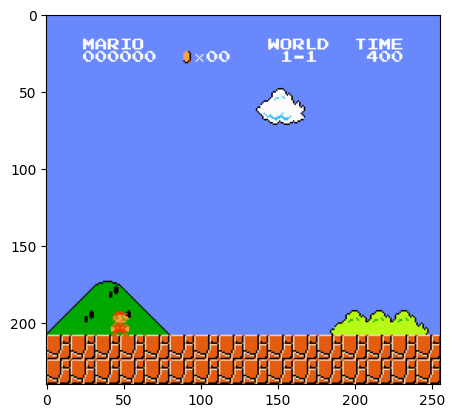

In [5]:
import matplotlib.pyplot as plt

state_rgb=env.render(mode='rgb_array');
plt.imshow(state_rgb);

# 3. Data Preprocessing

VecNormalize 

**3.0 Frame Preprocessing: Greyscaling and Stacking**

We process the game frames to make training more efficient and effective.

1. `Time Limit:` determines the maximum length of episode, original one for mario is 400 timesteps, however sometimes agent gets stuck, trying to jump over a pipe, if we is stuck for too much this wastes our training time, hence we should terminate earlier

1.  `Grayscaling:` Converting the image from color to grayscale reduces the data the AI must process from three color channels to one. This speeds up training significantly.

2. `DownSampling`: downsamping would decrease height,width of image shrinking it down, this makes training faster



4.  `Frame Stacking:` A single frame doesn't show movement. By stacking several consecutive frames, the AI can detect motion—like which way an enemy is moving or Mario is jumping. This solves a key problem: without a sequence of frames, the game state is "partially observable," violating the assumptions of a Markov Decision Process. Stacking frames creates a state that includes recent history, making the environment suitable for Reinforcement Learning.

5. `Frame Skipping:` It is a technique where agent takes an action for frame t, and repeat it for n number of frames, it is useful as it increases learning stability via making agent focus on marco strategy rather than micro strategy also known as `Temporal Abstraction`, where agent focuses on higher objective rather than small objective every timestep, such as for state s, take right, for state st+1, take left, for state st+2 take right, might lead to jittery behaviour if frame skipping was not used, also it speeds up training as Neural networks require a lot of resources to train, skipping calling Network every couple of frames speeds up learning, downside that it introduces hyperparameter which might need tweaking, and it is not recommended for games with fine-controls, where slightlest action or small move is important


**3.1 Frame Skipping**

In [6]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


env = SkipFrame(env, skip=4)

/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**3.2 Time Limit**

In [7]:
class GameTimeLimit(gym.Wrapper):
    def __init__(self,env):
        super().__init__(env)
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        if info["time"] == 200:
            terminated=True
            truncated=True
        return obs, reward, terminated, truncated, info

**3.3 Grayscaling**

using grayscaling technique would cut down information from `240x256x3 =>  184320`  to  `240x256x1 => 61440`, a reduction in information by about
`66.67%`

In [8]:
def DisplayComparsion(new_mode_text=""):
    fig, (ax_changed, ax_original_rgb) = plt.subplots(1,2, figsize=(10,8))
    state_grayscale = env.reset()
    state_rgb=env.render(mode='rgb_array');
    
    ax_changed.imshow(state_grayscale, cmap="gray");
    ax_changed.set_title(new_mode_text);
    ax_original_rgb.imshow(state_rgb);
    ax_original_rgb.set_title("Original Mario State");

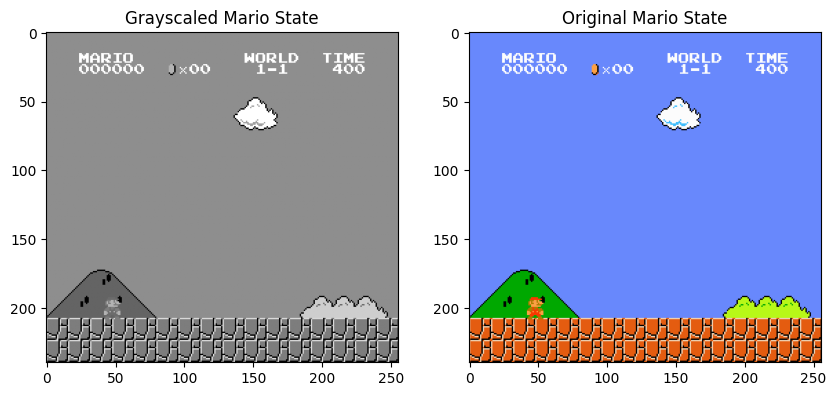

In [9]:
from gym.wrappers import  GrayScaleObservation, HumanRendering, StepAPICompatibility, ResizeObservation, FrameStack, NormalizeObservation

# 1. Creating Environment
env = gym_super_mario_bros.make("SuperMarioBros-v0",new_step_api=True);
# 2. Simplifying Controls
env = JoypadSpace(env, SIMPLE_MOVEMENT);
# 3. Grayscale Wrapper
env = GrayScaleObservation(env, keep_dim=True);

DisplayComparsion("Grayscaled Mario State")

**3.4 DownScaling**


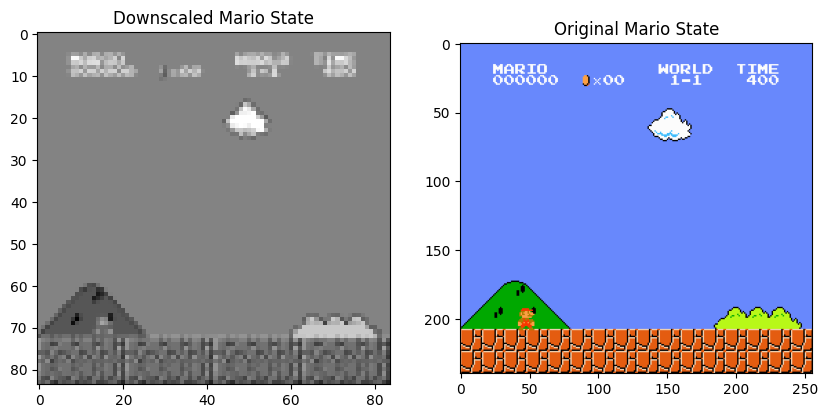

In [10]:
env = ResizeObservation(env, 84)
DisplayComparsion("Downscaled Mario State")


**3.5 Normalisation**

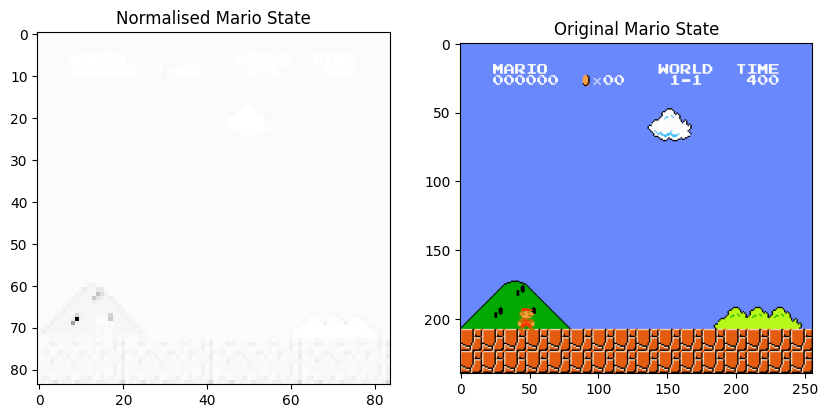

In [11]:
env = NormalizeObservation(env, new_step_api=True)
DisplayComparsion("Normalised Mario State")


**3.6 Frame Stacking**


In [12]:
num_stack=4

env = FrameStack(env,num_stack)

state_framestacked = env.reset()
state_framestacked.shape

(4, 84, 84, 1)

**3.7 Putting All Together**

In [13]:
from gym.wrappers import StepAPICompatibility
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import gym


class FixResetSeedWrapper(gym.Wrapper):
    def __init__(self,env):
        super().__init__(env)
    
    def reset(self,**kwargs):
        # Remove seed and options that JoypadSpace doesn't support
        # Just call reset without any arguments
        result = self.env.reset()
        return result, {}
    
class CustomRenderRGBImage(gym.ObservationWrapper):
    def __init__(self,env):
        super().__init__(env)
        self._last_rgb_image="Exists"
    
    def observation(self,obs):
        self._last_rgb_image = obs.copy()
        return obs
    
    def render_rgb_image(self):
        return self._last_rgb_image




def create_mario_env(level):
    frame_skip=4
    resize_by = 84

    env = gym_super_mario_bros.make(level,new_step_api=True);
    env = JoypadSpace(env, SIMPLE_MOVEMENT);
    env = SkipFrame(env, skip=frame_skip)
    env = GameTimeLimit(env)
    env = CustomRenderRGBImage(env)
    env = GrayScaleObservation(env, keep_dim=True);
    env = ResizeObservation(env, resize_by)
    env = NormalizeObservation(env, new_step_api=True)
    env = FixResetSeedWrapper(env);
    env = StepAPICompatibility(env, new_step_api=True)
    
    return env

#"SuperMarioBros-2-1-v0"
#"SuperMarioBros-v0"

env = DummyVecEnv([lambda: create_mario_env("SuperMarioBros-v0")])
env = VecFrameStack(env, 4, channels_order="last")

state=env.reset()
print("="*100)
print("Shape of state is",state.shape)
print("Number of values returned by Step() : ",len(env.step([1])))
print("="*100)


Shape of state is (1, 84, 84, 4)
Number of values returned by Step() :  4


/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


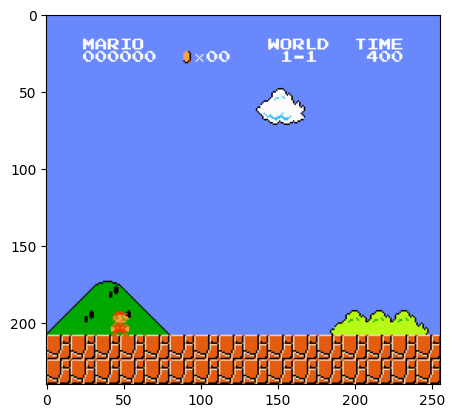

In [14]:
env.reset()
plt.imshow(env.envs[0].render_rgb_image())

# 4. Machine Learning

In [16]:
from stable_baselines3.common.callbacks import BaseCallback
import os

class TrainAndLoggingCallBack(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallBack, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True) # do not raise an error if the folder already exists
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

CHECKPOINT_DIR="final_models"
LOG_DIR="final_models_logs"
callback = TrainAndLoggingCallBack(check_freq=1000, save_path=CHECKPOINT_DIR)

In [18]:
from stable_baselines3 import PPO

# ppo_model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.00001, n_steps=512)


In [19]:
ppo_model = PPO.load("LATER_TRAIN//million_model.zip", env=env) 


Wrapping the env in a VecTransposeImage.


In [29]:
# # ppo_model.learn(10000,callback)
ppo_model.learn(total_timesteps=500000)

-----------------------------
| time/              |      |
|    fps             | 43   |
|    iterations      | 1    |
|    time_elapsed    | 25   |
|    total_timesteps | 1103 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 2           |
|    time_elapsed         | 48          |
|    total_timesteps      | 2206        |
| train/                  |             |
|    approx_kl            | 0.009467751 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.1         |
|    entropy_loss         | -0.338      |
|    explained_variance   | 0.769       |
|    learning_rate        | 2.13e-05    |
|    loss                 | 91.1        |
|    n_updates            | 19068       |
|    policy_gradient_loss | -0.00722    |
|    value_loss           | 208         |
-----------------------------------------
----------------------------------

# 5. Testing a single Agent

In [19]:
env.reset()
state, reward, done, info =env.step([1])
print(info[0])

{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79, 'TimeLimit.truncated': False}


In [22]:
import imageio

def MakeVideo(all_frames,save_path):
    imageio.mimwrite(save_path,all_frames,fps=30)
    print(f"Saved Video path {save_path}")

In [23]:
VIDEO_FOLDER="genetic_videos"
os.makedirs(VIDEO_FOLDER, exist_ok=True)

def Test_Agent(load_agent=False,model=None,model_name=""):
    if load_agent:
        try:
            model_path = os.path.join(CHECKPOINT_DIR,model_name)
            model=PPO.load(model_path)
        except Exception as e:
            print(f"Failed to Load {model_name}, Error in details : {e}")
            return
    
    state = env.reset()
    done=False

    all_states=[]
    all_actions=[]
    while not done:
        action, _ = model.predict(state)
        
        state, reward, done, info = env.step(action)
        state_rgb=env.envs[0].render_rgb_image();
        all_states.append(state_rgb.copy())
        all_actions.append(action)
    
    model_name_without_zip=model_name.replace(".zip",".mp4")
    video_path = os.path.join(VIDEO_FOLDER,model_name_without_zip)
    print("Video path is",video_path)
    MakeVideo(all_states,video_path)

# Test_Agent(load_agent=True,model_name="best_model_10000.zip")

In [22]:
from IPython.display import Video

Video("genetic_videos//best_model_10000.mp4")

**4.2 Hyperparameters**

In [ ]:
LEARNING_RATE = 0.0001
GAE = 1.0
GAMMA = 0.9
BATCH_SIZE = 64
N_EPOCHS = 10
ENT_COEF = 0.01

**4.3 Hyperparameter Tunning Smartly**

In [33]:
import numpy as np
from bayes_opt import BayesianOptimization
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

class TuneModel:
    def __init__(self, env, total_timesteps=10000, n_eval_episodes=5):
        self.env = env
        self.total_timesteps = total_timesteps
        self.n_eval_episodes = n_eval_episodes

    def ppo_training_objective(self, learning_rate, n_steps, batch_size, 
                              gae_lambda, clip_range, ent_coef, n_epochs, gamma=0.99):
        """
        Objective function for Bayesian Optimization
        Note: This method must take the parameters as arguments
        """
        try:
            # Convert parameters to appropriate types and scales
            learning_rate = 10 ** learning_rate  # Log scale
            n_steps = int(n_steps)
            batch_size = int(batch_size)
            n_epochs = int(n_epochs)
            
            print(f"Training with: lr={learning_rate:.2e}, n_steps={n_steps}, batch_size={batch_size}")
            
            # Create and train model
            model = PPO(
                "CnnPolicy", 
                self.env, 
                learning_rate=learning_rate, 
                n_steps=n_steps,
                batch_size=batch_size,
                gae_lambda=gae_lambda,
                clip_range=clip_range, 
                ent_coef=ent_coef, 
                n_epochs=n_epochs,
                gamma=gamma,
                verbose=0
            )
            
            # Train the model
            model.learn(total_timesteps=self.total_timesteps)
            
            # Evaluate the model
            average_reward, std_reward = evaluate_policy(
                model, 
                self.env, 
                n_eval_episodes=self.n_eval_episodes, 
                deterministic=True
            )
            
            # Clean up
            del model
            
            print(f"Average reward: {average_reward:.2f}")
            return average_reward
            
        except Exception as e:
            print(f"Error in training: {e}")
            return 0.0  # Return minimum reward if training fails

    def setup_bayesian_optimisation(self):
        """Set up Bayesian Optimization with parameter bounds"""
        
        # We need to create a wrapper function that BayesianOptimization can call
        def objective_wrapper(learning_rate, n_steps, batch_size, gamma, 
                            gae_lambda, clip_range, ent_coef, n_epochs):
            return self.ppo_training_objective(
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                clip_range=clip_range,
                ent_coef=ent_coef,
                n_epochs=n_epochs
            )

        pbounds = {
            'learning_rate': (-5, -2),        # 10^-5 to 10^-2
            'n_steps': (64, 2048),            # Number of steps per update
            'batch_size': (32, 256),          # Minibatch size
            'gamma': (0.9, 0.999),            # Discount factor
            'gae_lambda': (0.9, 0.99),        # GAE parameter
            'clip_range': (0.1, 0.3),         # Clipping parameter
            'ent_coef': (0.0, 0.01),          # Entropy coefficient
            'n_epochs': (3, 20)               # Number of optimization epochs
        }

        optimiser = BayesianOptimization(
            f=objective_wrapper,
            pbounds=pbounds, 
            random_state=42, 
            verbose=2
        )

        return pbounds, optimiser
    
    def start_tunning(self, n_iter=15, init_points=5):
        """Start the Bayesian Optimization process"""
        pbounds, optimiser = self.setup_bayesian_optimisation()

        # Run optimization
        optimiser.maximize(n_iter=n_iter, init_points=init_points)

        # Get best results
        best_result = optimiser.max
        
        print("=" * 50)
        print("HYPERPARAMETER TUNING RESULTS")
        print("=" * 50)
        
        for param, value in best_result["params"].items():
            print(f"Parameter: {param:15} Value: {value}")
        
        print("*" * 50)
        print(f"Best Reward: {best_result['target']:.2f}")
        print("=" * 50)
        
        return best_result
    
tuner = TuneModel(
    env=env,
    total_timesteps=10000,  # Short training for quick optimization
    n_eval_episodes=3       # Fewer episodes for faster evaluation
)

tuner.start_tunning()


|   iter    |  target   | learni... |  n_steps  | batch_... |   gamma   | gae_la... | clip_r... | ent_coef  | n_epochs  |
-------------------------------------------------------------------------------------------------------------------------
Training with: lr=1.33e-04, n_steps=1950, batch_size=195
Average reward: 300.67
| 1         | 300.66666 | -3.876379 | 1950.2171 | 195.96664 | 0.9592671 | 0.9140416 | 0.1311989 | 0.0005808 | 17.724994 |
Training with: lr=6.36e-04, n_steps=1468, batch_size=36
Average reward: 680.00
| 2         | 680.0     | -3.196654 | 1468.8159 | 36.610926 | 0.9960210 | 0.9749198 | 0.1424678 | 0.0018182 | 6.1178766 |
Training with: lr=8.18e-05, n_steps=1105, batch_size=128
Average reward: 725.00
| 3         | 725.0     | -4.087273 | 1105.1167 | 128.75568 | 0.9288316 | 0.9550667 | 0.1278987 | 0.0029214 | 9.2281513 |
Training with: lr=2.33e-04, n_steps=1621, batch_size=76
Average reward: 495.00
| 4         | 495.0     | -3.631790 | 1621.7891 | 76.726927 | 0.9509092 

{'target': 737.0,
 'params': {'learning_rate': -4.672253552165803,
  'n_steps': 1102.8898260432752,
  'batch_size': 123.30766009251346,
  'gamma': 0.9,
  'gae_lambda': 0.99,
  'clip_range': 0.1,
  'ent_coef': 0.0,
  'n_epochs': 14.216266664259633}}

In [34]:
total_timesteps=1000_000
CHECKPOINT_DIR="/PPO_TRAINED_MODELS"
callback = TrainAndLoggingCallBack(check_freq=100000, save_path=CHECKPOINT_DIR)

In [36]:
model = PPO(
    "CnnPolicy", 
    env,
    learning_rate=2.13e-5,
    n_steps=1103,
    batch_size=123,
    gamma=0.9,
    gae_lambda=0.99,
    clip_range=0.1,
    ent_coef=0.0,
    n_epochs=14,
    verbose=1
)
            
model.learn(total_timesteps=total_timesteps, callback=callback)

Using cuda device
Wrapping the env in a VecTransposeImage.
-----------------------------
| time/              |      |
|    fps             | 52   |
|    iterations      | 1    |
|    time_elapsed    | 21   |
|    total_timesteps | 1103 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 2           |
|    time_elapsed         | 44          |
|    total_timesteps      | 2206        |
| train/                  |             |
|    approx_kl            | 0.003787982 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.00316    |
|    learning_rate        | 2.13e-05    |
|    loss                 | 505         |
|    n_updates            | 14          |
|    policy_gradient_loss | -0.00694    |
|    value_loss           | 1.53e+03    |
-----------------

In [39]:
os.makedirs("LATER_TRAIN",exist_ok=True)
ppo_model.save("LATER_TRAIN//two_million")

In [37]:
Test_Agent(model=ppo_model,model_name="million3_model.mp4")

Video path is genetic_videos/million3_model.mp4
Saved Video path genetic_videos/million3_model.mp4


# 6. Genetic Algorithm

In [23]:
import time
import numpy as np
import torch
import copy

KEY_ORDER = ['features_extractor.cnn.0.weight',
 'features_extractor.cnn.0.bias',
 'features_extractor.cnn.2.weight',
 'features_extractor.cnn.2.bias',
 'features_extractor.cnn.4.weight',
 'features_extractor.cnn.4.bias',
 'features_extractor.linear.0.weight',
 'features_extractor.linear.0.bias',
 'pi_features_extractor.cnn.0.weight',
 'pi_features_extractor.cnn.0.bias',
 'pi_features_extractor.cnn.2.weight',
 'pi_features_extractor.cnn.2.bias',
 'pi_features_extractor.cnn.4.weight',
 'pi_features_extractor.cnn.4.bias',
 'pi_features_extractor.linear.0.weight',
 'pi_features_extractor.linear.0.bias',
 'vf_features_extractor.cnn.0.weight',
 'vf_features_extractor.cnn.0.bias',
 'vf_features_extractor.cnn.2.weight',
 'vf_features_extractor.cnn.2.bias',
 'vf_features_extractor.cnn.4.weight',
 'vf_features_extractor.cnn.4.bias',
 'vf_features_extractor.linear.0.weight',
 'vf_features_extractor.linear.0.bias',
 'action_net.weight',
 'action_net.bias',
 'value_net.weight',
 'value_net.bias']

class MarioAgent:
    def __init__(self, episodes, level, agent_generation, chromosomes=None):
        self.episodes = episodes
        self.level = level
        self.model = None
        self.fitness = 0.0
        self.agent_generation = agent_generation
        self.name = f"PPO_{episodes}_Generation_{agent_generation}"
        self.chromosomes = chromosomes
        self.time_taken = 0
        
        # Create model first
        self.CreateModel()
        
        # Then handle chromosomes
        if self.chromosomes is not None and len(self.chromosomes) > 0:
            start_time = time.time()
            self.LoadWeights()
            # self.model.learn(total_timesteps=self.episodes)
            self.time_taken = time.time() - start_time
        else:
            start_time = time.time()
            # self.model.learn(total_timesteps=self.episodes)
            self.time_taken = time.time() - start_time
            self.BuildChromosomes()

        self.save_path = f"generation_{agent_generation}_folder"
        self.CalculateFitness()

    def LoadWeights(self):
        """
        Load weights from chromosomes (cloned tensors) into the model
        """
        try:
            state_dict = {}
            for i, key in enumerate(KEY_ORDER):
                if i < len(self.chromosomes):
                    # Clone the tensor to avoid reference issues
                    state_dict[key] = self.chromosomes[i].clone().detach()
            
            self.model.policy.load_state_dict(state_dict, strict=True)
        except Exception as e:
            print(f"Error loading weights: {e}")
            print(f"Expected keys: {len(KEY_ORDER)}, Got chromosomes: {len(self.chromosomes)}")
            raise
    
    def BuildChromosomes(self):
        """
        Extract weights from model and store as cloned tensors
        """
        self.chromosomes = []
        weights = self.model.policy.state_dict()
        
        for key in KEY_ORDER:
            if key in weights:
                # Clone and detach to create independent copies
                self.chromosomes.append(weights[key].clone().detach())
            else:
                print(f"Warning: Key {key} not found in model state_dict")

    def CreateModel(self):
        """
        Create the PPO model with consistent architecture
        """
        env = DummyVecEnv([lambda: create_mario_env(self.level)])
        env = VecFrameStack(env, 4, channels_order="last")
        
        model = PPO(
            'CnnPolicy', 
            env, 
            tensorboard_log=LOG_DIR, 
            learning_rate=0.00001, 
            n_steps=512
        )
        self.model = model

    def CalculateFitness(self):
        """
        Improved fitness calculation for Mario game
        """
        total_fitness = 0.0
        num_episodes = 1
        
        for episode in range(num_episodes):
            episode_fitness = 0.0
            max_x_pos = 0.0
            coins_collected = 0
            total_score = 0.0
            won_level = False
            time_penalty = 0
            steps = 0
            max_steps = 1000
            
            state = env.reset()
            done = False
            
            while not done and steps < max_steps:
                action, _ = self.model.predict(state, deterministic=True)
                state, reward, done, info = env.step(action)
                
                current_info = info[0] if isinstance(info, (list, tuple)) else info
                
                if current_info["x_pos"] > max_x_pos:
                    max_x_pos = current_info["x_pos"]
                
                coins_collected = current_info["coins"]
                total_score = current_info["score"]
                
                if current_info.get("flag_get", False):
                    won_level = True
                    break
                
                steps += 1
            
            time_penalty = steps * 0.1
            
            distance_bonus = 0
            if max_x_pos > 500:
                distance_bonus = max_x_pos * 15
            elif max_x_pos > 200:
                distance_bonus = max_x_pos * 12
            else:
                distance_bonus = max_x_pos * 10
            
            coin_bonus = coins_collected * 100
            score_bonus = total_score * 0.5
            level_completion_bonus = 10000 if won_level else 0
            
            progress_bonus = 0
            if max_x_pos > 1000:
                progress_bonus += 2000
            if max_x_pos > 2000:
                progress_bonus += 3000
            if max_x_pos > 3000:
                progress_bonus += 5000
            
            survival_bonus = steps * 2
            
            episode_fitness = (
                distance_bonus +
                coin_bonus +
                score_bonus +
                level_completion_bonus +
                progress_bonus +
                survival_bonus -
                time_penalty
            )
            
            total_fitness += episode_fitness
        
        self.fitness = total_fitness / num_episodes
        return self.fitness

    def GetAgentInformation(self):
        print("=" * 100)
        print("Agent Name:", self.name)
        print("Agent Trained for:", self.episodes)
        print("Agent Generation is:", self.agent_generation)
        print("Agent Fitness is:", self.fitness)
        print("len of chromosome:", len(self.chromosomes))
        print("Agent Model is:", self.model)
        print("Mario Level trained on:", self.level)
        print("Time Taken to train:", self.time_taken)
        print("=" * 100)

    def SaveAgent(self):
        os.makedirs(self.save_path, exist_ok=True)
        model_path = os.path.join(self.save_path, self.name)
        self.model.save(model_path)

In [24]:
import numpy as np
import random
import torch

class GeneticAlgorithm:
    def __init__(self, max_generations=500, mutation_rate=0.8, sigma=0.5, k=3,population_size=20):
        self.population = []
        self.generations = 0
        self.max_generations = max_generations
        self.population_size=population_size
        self.best_agent = None
        self.best_fitness = 0.0
        self.average_fitness = 0.0
        self.split_point = 14  # Split at middle of 28 chromosomes
        self.mutation_rate = mutation_rate
        self.chromosome_length = 28
        self.sigma = sigma
        self.k = k
        self.episodes = 100
        
        # Graph purposes
        self.list_best_fitness = []
        self.list_average_fitness = []
        
        self.initalize_population()

    def initalize_population(self):
        """Creating initial population"""
        for _ in range(self.population_size):
            mario_agent = MarioAgent(
                episodes=self.episodes,
                level="SuperMarioBros-v0",
                agent_generation=self.generations
            )
            self.population.append(mario_agent)
        
        # for _ in range(5):
        #     mario_agent = MarioAgent(
        #         episodes=self.episodes,
        #         level="SuperMarioBros-2-1-v0",
        #         agent_generation=self.generations
        #     )
        #     self.population.append(mario_agent)
        

        # for _ in range(5):
        #     mario_agent = MarioAgent(
        #         episodes=self.episodes,
        #         level="SuperMarioBros-5-1-v0",
        #         agent_generation=self.generations
        #     )
        #     self.population.append(mario_agent)
        print("Finished Initalisation!")

    def select_parent(self):
        """
        Tournament selection: sample k individuals, return best
        """
        group = random.sample(self.population, k=self.k)
        
        best_fitness = -float('inf')
        best_agent = None
        
        for individual in group:
            if individual.fitness > best_fitness:
                best_agent = individual
                best_fitness = individual.fitness
        
        return best_agent

    def crossover(self, agent_one, agent_two):
        """
        Single-point crossover on chromosome tensors
        Returns two new chromosome lists
        """
        offspring_chromosomes_one = []
        offspring_chromosomes_two = []
        
        # First offspring: first part from parent 1, second part from parent 2
        for i in range(self.chromosome_length):
            if i < self.split_point:
                offspring_chromosomes_one.append(agent_one.chromosomes[i].clone().detach())
                offspring_chromosomes_two.append(agent_two.chromosomes[i].clone().detach())
            else:
                offspring_chromosomes_one.append(agent_two.chromosomes[i].clone().detach())
                offspring_chromosomes_two.append(agent_one.chromosomes[i].clone().detach())
        
        return offspring_chromosomes_one, offspring_chromosomes_two

    def assign_level_to_offspring(self):
            """Assign level to offspring maintaining the desired distribution"""
            level_counts = {
                "SuperMarioBros-v0": self.count_level("SuperMarioBros-v0"),
                "SuperMarioBros-2-1-v0": self.count_level("SuperMarioBros-2-1-v0"),
                "SuperMarioBros-5-1-v0": self.count_level("SuperMarioBros-5-1-v0")
            }
            
            # Find which levels need more agents
            needed_levels = []
            if level_counts["SuperMarioBros-v0"] < 15:
                needed_levels.append("SuperMarioBros-v0")
            if level_counts["SuperMarioBros-2-1-v0"] < 5:
                needed_levels.append("SuperMarioBros-2-1-v0")
            if level_counts["SuperMarioBros-5-1-v0"] < 5:
                needed_levels.append("SuperMarioBros-5-1-v0")
            
            # If all levels have enough agents, choose randomly but maintain distribution
            if not needed_levels:
                # Calculate current distribution ratios
                total = len(self.population)
                ratios = {
                    "SuperMarioBros-v0": level_counts["SuperMarioBros-v0"] / total,
                    "SuperMarioBros-2-1-v0": level_counts["SuperMarioBros-2-1-v0"] / total,
                    "SuperMarioBros-5-1-v0": level_counts["SuperMarioBros-5-1-v0"] / total
                }
                
                # Choose level based on how far it is from target distribution
                target_ratios = {"SuperMarioBros-v0": 0.6, "SuperMarioBros-2-1-v0": 0.2, "SuperMarioBros-5-1-v0": 0.2}
                deviations = {level: target_ratios[level] - ratios[level] for level in target_ratios}
                
                # Choose level with highest positive deviation (most underrepresented)
                return max(deviations, key=deviations.get)
            else:
                # Choose randomly from needed levels
                return random.choice(needed_levels)
    def mutate(self, offspring_chromosomes):
        """
        Applies Gaussian mutation to chromosome tensors
        """
        mutated_chromosome = []
        
        for i in range(self.chromosome_length):
            # Clone the tensor
            gene = offspring_chromosomes[i].clone().detach()
            
            # Apply mutation with probability mutation_rate
            if np.random.random() < self.mutation_rate:
                # Add Gaussian noise to the entire tensor
                noise = torch.randn_like(gene) * self.sigma
                gene = gene + noise
            
            mutated_chromosome.append(gene)
        


        # Select level
        # if np.random.random() < 0.5:
        #     level = "SuperMarioBros-v0"
        # else:
        #     level = "SuperMarioBros-2-1-v0"
        # level = self.assign_level_to_offspring()
        level = "SuperMarioBros-v0"
        # Create offspring agent
        offspring_agent = MarioAgent(
            episodes=self.episodes,
            level=level,
            agent_generation=self.generations,
            chromosomes=mutated_chromosome
        )
        
        return offspring_agent

    def get_best_agent(self):
        """Find and return the best agent in population"""
        for individual in self.population:
            if individual.fitness > self.best_fitness:
                self.best_agent = individual
                self.best_fitness = individual.fitness
        return self.best_agent

    def calculate_average_fitness(self):
        """Calculate average fitness of population"""
        all_fitnesses = [individual.fitness for individual in self.population]
        self.average_fitness = np.mean(all_fitnesses)

    def update_graph_lists(self):
        """Store fitness history for plotting"""
        self.list_best_fitness.append(self.best_fitness)
        self.list_average_fitness.append(self.average_fitness)

    def count_level(self, level):
        """Count how many agents are training on a specific level"""
        return len([individual for individual in self.population if individual.level == level])

    def average_fitness_per_level(self, level):
        all_fitnesses = [individual.fitness for individual in self.population if individual.level==level]
        self.average_fitness = np.mean(all_fitnesses)

    def best_fitness_per_level(self, level):
        all_fitnesses = [individual.fitness for individual in self.population if individual.level==level]
        self.average_fitness = np.max(all_fitnesses)

    def display_information(self):
        """Display generation statistics"""
        print("=" * 100)

        print(f"Generation: {self.generations}")
        print(f"Population Size: {len(self.population)}")
        print(f"Best Fitness: {self.best_fitness:.2f}")
        print(f"Average Fitness: {self.average_fitness:.2f}")
        print(f"Level [SuperMarioBros-v0]: {self.count_level('SuperMarioBros-v0')} agents")
        # print(f"Level [SuperMarioBros-2-1-v0]: {self.count_level('SuperMarioBros-2-1-v0')} agents")
        # print(f"Level [SuperMarioBros-5-1-v0]: {self.count_level('SuperMarioBros-5-1-v0')} agents")
        # print("*"*100)

        # print(f"Best Fitness for Level [SuperMarioBros-v0]: {self.best_fitness_per_level('SuperMarioBros-v0')}")
        # print(f"Best Fitness for Level [SuperMarioBros-2-1-v0]: {self.best_fitness_per_level('SuperMarioBros-2-1-v0')}")
        # print(f"Best Fitness for Level [SuperMarioBros-5-1-v0]: {self.best_fitness_per_level('SuperMarioBros-5-1-v0')}")
        # print(f"Average Fitness for Level [SuperMarioBros-v0]: {self.average_fitness_per_level('SuperMarioBros-v0')}")
        # print(f"Average Fitness for Level [SuperMarioBros-2-1-v0]: {self.average_fitness_per_level('SuperMarioBros-2-1-v0')}")
        # print(f"Average Fitness for Level [SuperMarioBros-5-1-v0]: {self.average_fitness_per_level('SuperMarioBros-5-1-v0')}")


        print("=" * 100)

    def evolution(self):
        """Main evolutionary loop"""
        while self.generations < self.max_generations:
            new_population = []
            
            # Generate offspring until we have enough
            while len(new_population) < len(self.population) - 1:
                # Select parents
                parent_one = self.select_parent()
                parent_two = self.select_parent()
                
                # Crossover
                offspring_chromosomes_one, offspring_chromosomes_two = self.crossover(
                    parent_one, parent_two
                )
                
                # Mutate
                offspring_one = self.mutate(offspring_chromosomes_one)
                offspring_two = self.mutate(offspring_chromosomes_two)
                
                new_population.append(offspring_one)
                if len(new_population) < len(self.population) - 1:
                    new_population.append(offspring_two)
            
            # Elitism: keep best agent
            best_agent = self.get_best_agent()

            #   Save best agent in that generation
            best_agent.SaveAgent()
            new_population.append(best_agent)
            
            # Update statistics
            self.calculate_average_fitness()
            self.update_graph_lists()
            
            # Replace population
            self.population = new_population
            
            # Display info
            self.display_information()
            
            # Increment generation
            self.generations += 1
        
        print("\nEvolution complete!")
        print(f"Final best fitness: {self.best_fitness:.2f}")





In [25]:
genetic_algorithm=GeneticAlgorithm()

/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


KeyboardInterrupt: 

In [ ]:
genetic_algorithm.evolution()

Generation: 0
Population Size: 20
Best Fitness: 12570.00
Average Fitness: 5186.58
Level [SuperMarioBros-v0]: 20 agents
Generation: 1
Population Size: 20
Best Fitness: 12845.00
Average Fitness: 4965.68
Level [SuperMarioBros-v0]: 20 agents
Generation: 2
Population Size: 20
Best Fitness: 14695.00
Average Fitness: 7989.90
Level [SuperMarioBros-v0]: 20 agents
Generation: 3
Population Size: 20
Best Fitness: 14695.00
Average Fitness: 5871.81
Level [SuperMarioBros-v0]: 20 agents
Generation: 4
Population Size: 20
Best Fitness: 14695.00
Average Fitness: 6424.09
Level [SuperMarioBros-v0]: 20 agents
Generation: 5
Population Size: 20
Best Fitness: 14695.00
Average Fitness: 7286.59
Level [SuperMarioBros-v0]: 20 agents
Generation: 6
Population Size: 20
Best Fitness: 15650.00
Average Fitness: 7810.30
Level [SuperMarioBros-v0]: 20 agents
Generation: 7
Population Size: 20
Best Fitness: 15650.00
Average Fitness: 7421.20
Level [SuperMarioBros-v0]: 20 agents
Generation: 8
Population Size: 20
Best Fitness: 

KeyboardInterrupt: 

In [ ]:
Test_Agent(model=genetic_algorithm.get_best_agent().model,model_name="genetic_algorithm_100.mp4")

Video path is genetic_videos/genetic_algorithm_100.mp4
Saved Video path genetic_videos/genetic_algorithm_100.mp4


In [ ]:
ppo_model_best=genetic_algorithm.get_best_agent().model